**From SMLM to machine learning - Tutorial**

This program enables the use of persistent images as vector representation of structural properties of SMLM to make further analysis like Principal Component Analysis (PCA)

**Load Data and Packages**

Put your datasets of Orte files in the folder "datasetsOrte"

In [1]:
import os
from tkinter.messagebox import NO
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Put your datasets of Orte files in the following folder:
# in this example cancer and skin cells are compared, 
datasetFolder = "datasetsOrte"

# If set to N, N blink events are selected for each cell randomly
# If nucleus has less counts it is not considered.
# This can be useful for the comparison of cells with a different count numbers.
# But be careful, different count numbers can be biologically important and should not always be normalized.
normalizeCounts = 1000 #None 

# Normalize cells to size in um**2
# This can be useful for the comparison of cells with a different size. 
# But be careful, different sizes can be biologically important and should not always be normalized. 
cellSizeArea = None #100 #None

_, datasetNames, _ = next(os.walk(datasetFolder))

**Persistent Homology:**

In [2]:
# Do persistent Homology
allResults = {}
for dataset in datasetNames:
    _, _, filenames = next(os.walk(os.path.join(datasetFolder, dataset)))

    allResults[dataset] = {}

    for filename in filenames:
        if not ".csv" in filename:
            print(filename, " is not .csv format")
            continue

        

        path = os.path.join(datasetFolder, dataset ,filename)
        orteData = np.genfromtxt(path, delimiter=',', skip_header=5).T

        # normalize counts
        if normalizeCounts != None:

            if orteData.shape[1] > normalizeCounts + 1:
                mask = np.random.choice(np.arange( orteData.shape[1] ), normalizeCounts, replace = False)

                orteData = orteData.T[mask].T

            if orteData.shape[1] < normalizeCounts - 1:
                print('count number smaller than ', normalizeCounts,'not used: ', dataset, " ", filename )
                continue

        if cellSizeArea != None:

            reloadData = np.genfromtxt(path, usecols= 6,
                                    delimiter=',').T
            area = reloadData[1]
            cellSizeArea_nm = cellSizeArea * 1000000
            orteData[1:3] = orteData[1:3] / area * cellSizeArea_nm
            

                         
        finalFilterdOrte = orteData[1:3].T

        # apply persistent homology with alpha complex
        acX = gd.AlphaComplex(points=finalFilterdOrte).create_simplex_tree()
        dgmX = acX.persistence()

        # get the hole / betti number dimension 1 values
        oneDimValues = np.sqrt(acX.persistence_intervals_in_dimension(1))
        print(oneDimValues)
        #break
        allResults[dataset][filename] = oneDimValues

[[  1.77184802   1.78870565]
 [  2.9411277    2.94180568]
 [  3.45020802   3.48500007]
 ...
 [267.83431755 630.6281379 ]
 [791.66286209 793.94584678]
 [262.04433493 804.21618493]]
[[  4.51853995   4.63110074]
 [  6.07013535   6.08389549]
 [  6.08388644   6.51843214]
 ...
 [267.1212329  653.26905403]
 [692.65646597 693.7522796 ]
 [312.23789183 705.26283649]]
[[  3.47545002   3.5926036 ]
 [  4.48772773   4.78307461]
 [  6.44266994   6.64309437]
 ...
 [228.38998957 580.99592545]
 [432.72868755 625.4593009 ]
 [749.27970359 751.38335021]]
[[  3.93110657   4.35073658]
 [  4.66220343   4.84103485]
 [  4.85601163   4.97080024]
 ...
 [215.39746351 506.64420939]
 [237.60682826 509.61288556]
 [188.76965491 518.1496786 ]]
[[  5.30672747   5.56767445]
 [  5.92142826   6.23743074]
 [  7.22273879   7.29655708]
 ...
 [348.89694212 533.57405608]
 [539.20204047 540.56597123]
 [266.01707735 541.60883457]]
[[  4.73076539   5.07994659]
 [  6.02588545   6.242264  ]
 [  6.04517224   6.30780324]
 ...
 [436.27

Take a look at the Persistent Homology results:

Text(0.5, 1.0, 'Barcode dim 1 / holes skinCells 45_3_Orte_in_nucleus.csv')

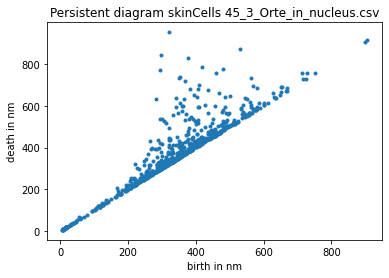

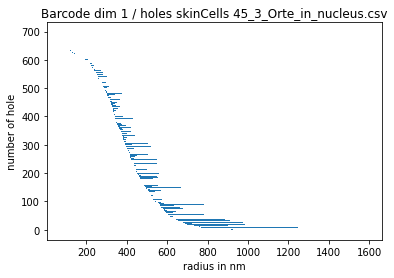

In [3]:
#%% plot example persistent diagram
setExample = "skinCells"
filenamExample = "45_3_Orte_in_nucleus.csv"

birth, death = allResults[setExample][filenamExample].T
plt.scatter(birth, death, marker = ".")
plt.xlabel("birth in nm")
plt.ylabel("death in nm")
title = "Persistent diagram " + setExample + " " + filenamExample 
plt.title(title)

plt.figure()
plt.barh(np.arange(len(death)), width = np.flip(death - birth), left = np.flip(death) )
plt.xlabel("radius in nm")
plt.ylabel(" number of hole ")
title = "Barcode dim 1 / holes " + setExample + " " + filenamExample 
plt.title(title)

Now the persistent homology results are converted into a vector format. 

In this case this is in the form of a persistent image. On the top you can set the resolution parameters.

Finally, some example images are drawn.

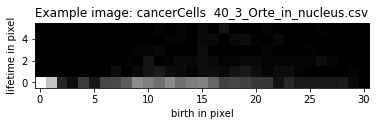

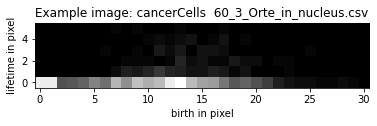

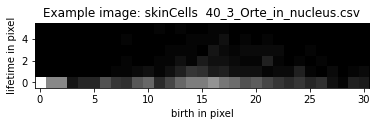

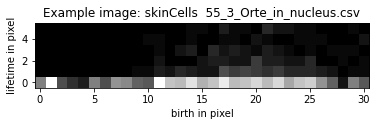

In [4]:
# set side length of persistent image
limBirth = 500 
limLifetime = 100

# set approximate number of pixel depending on side length above
totalPixelsApprox = 200

persistentImageFolder = "PersistenceImages FilterCounts_" + str(normalizeCounts) + " limBirth_" + str(limBirth) + " limLifetime_" + str(limLifetime) + " resolution_ " + str(totalPixelsApprox)
folderToSaveResults = os.path.join( persistentImageFolder )
if os.path.exists(folderToSaveResults) == False:
        os.mkdir(folderToSaveResults)

for slide, values in allResults.items():
    
    folderToSaveResultsSlide = os.path.join(folderToSaveResults, slide)
    if os.path.exists(folderToSaveResultsSlide) == False:
        os.mkdir(folderToSaveResultsSlide)
    else:
        print('delete old images')
        for f in os.listdir(folderToSaveResultsSlide):
            os.remove(os.path.join(folderToSaveResultsSlide, f)) 

    i = 0
    for filename, dim1values in values.items():
        
        xRes = int( np.sqrt( limBirth * totalPixelsApprox / limLifetime))
        yRes = int( np.sqrt( limLifetime * totalPixelsApprox / limBirth))

        heatmap, xedges, yedges = np.histogram2d(dim1values.T[0], dim1values.T[1] -  dim1values.T[0], bins = (xRes,yRes), range = [[0, limBirth], [0, limLifetime]])
        imgArray = heatmap.T
        cm = plt.cm.get_cmap('gray')

        plt.imsave(os.path.join(folderToSaveResultsSlide, filename.split('.')[0] + ".png"), imgArray, cmap = cm, origin = "lower")

        if i%15  == 0:
            plt.figure()
            plt.title("Example image: "+slide+"  "+ filename)
            plt.imshow(imgArray, cmap = cm, origin = "lower")
            plt.xlabel("birth in pixel")
            plt.ylabel("lifetime in pixel")
        i +=1

        np.save(os.path.join(folderToSaveResultsSlide, filename.split('.')[0] + ".npy"), imgArray)

**Use the persistent images for statistics and machine learning**

y = f(X) is the general function that can be fitted by a classifier

yData contains the labels: in this case if the cell is skin or cancer cell

xData contains the data, in this case the persistence data in form of a persistent image

-"folderToSaveResults" must contain one folder for each dataset including persistent images 


In [5]:
#%% use the persistent images with PCA for example
# "folderToSaveResults" must contain one folder for each dataset including persistent images 

# y = f(X) is the general function that can be fitted by a classifier
# yData contains the labels: in this case if the cell is skin or cancer cell
# xData contains the data, in this case the persistence data in form of a persistent image
xData, yData = [], []

for slide, values in allResults.items():

    folder = os.path.join(folderToSaveResults, slide)
    _, _, filenames = next(os.walk(folder))
    
    for filename in filenames:
    
        if not '.npy' in filename:
            continue
    
        im = np.load(os.path.join(folder, filename))    
        globalXDim, globalYDim = im.shape[1], im.shape[0]
        reshaped = im.reshape(globalXDim * globalYDim)
 
        xData.append(reshaped)
        yData.append(slide)
    
xData

[array([55., 42.,  8.,  3., 13.,  5., 15., 16., 20., 30., 27., 24., 30.,
        24., 27., 28., 22., 14., 15., 14., 12., 12.,  4.,  9.,  5.,  5.,
         5.,  5.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
         0.,  2.,  4.,  6.,  3.,  2.,  1.,  3.,  3.,  2.,  4.,  6.,  3.,
         1.,  3.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  4.,  0.,  1.,  2.,  2.,  3.,
         2.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         2.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  2.,  0.,  2.,
         3.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  2.,  0.,  4.,  0.,  0.,  0.,  1.,  0.

**Principal Component Analysis**

Only the xData is needed as the algorithm is unsupervised

In [6]:

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

# standardize data
xData = StandardScaler().fit_transform(xData)

pca = decomposition.PCA(n_components=20)
principalComponents = pca.fit_transform(xData).T
comp = pca.components_
variances = pca.explained_variance_ratio_


Scree Plot

<BarContainer object of 10 artists>

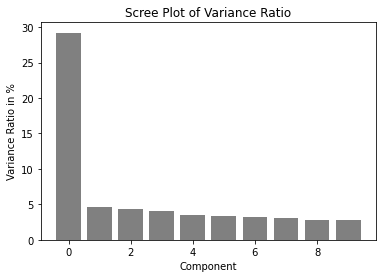

In [7]:
plotFirstN = 10
plt.title('Scree Plot of Variance Ratio')
plt.xlabel('Component')
plt.ylabel('Variance Ratio in %')
plt.bar(np.arange(plotFirstN), variances[:plotFirstN]*100, color = "gray")


Plot a projection along two components.

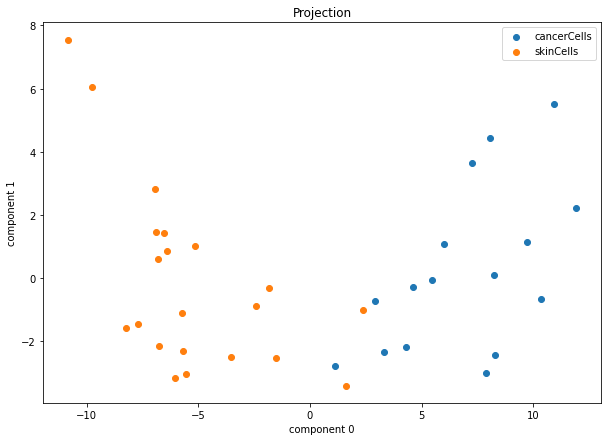

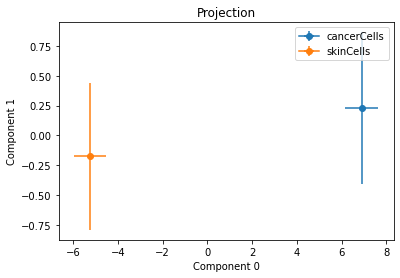

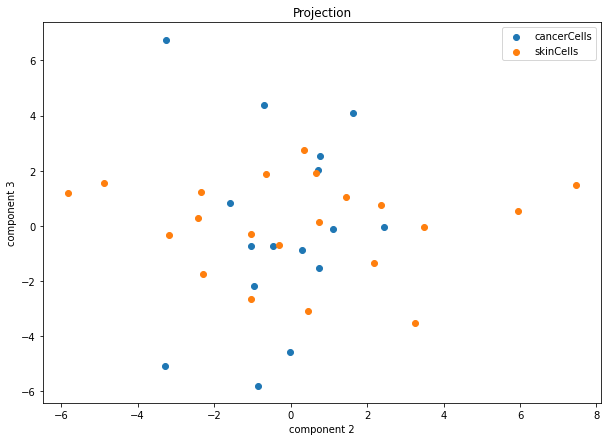

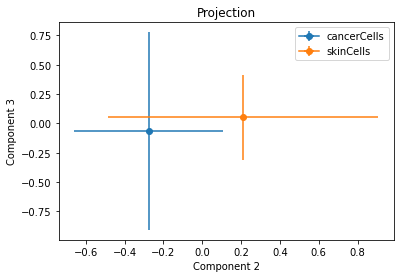

In [8]:
componentsToPlot = [ [0,1]] #, [1,2], [0,2]]

plotMean = True

defcolors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for comps in componentsToPlot:
    means, stds, labels, stdXYs, colorsChosen = [], [], [], [], []
    plt.figure(figsize=(10,7))
    
    allLabels = np.unique( yData)
    for i in range(len(allLabels)):
        mask = yData == np.array(allLabels[i])
        marker = "o"
        comp1, comp2 =comps[0],comps[1]
        achsis1 = principalComponents[comp1][mask]
        achsis2 = principalComponents[comp2][mask]
        label = allLabels[i]
        labels.append(label)
        plt.scatter(achsis1, achsis2, label= label,  marker=marker, color=defcolors[i])
        plt.xlabel('component ' + str(comp1))
        plt.ylabel('component ' + str(comp2))
        plt.title("Projection")
        plt.legend()
        
        mean = [np.mean(achsis1), np.mean(achsis2)]
        means.append(mean)
        stdXY = [np.std(achsis1)/np.sqrt(len(achsis1)), np.std(achsis2)/np.sqrt(len(achsis2))]
        stdXYs.append(stdXY)
        colorsChosen.append(defcolors[i])
    
    if plotMean:
        plt.figure()
        for i in range(len(means)):
            marker = "o"
            
            #ACHTUNG
            plt.errorbar(means[i][0], means[i][1],yerr = stdXYs[i][1], xerr= stdXYs[i][0], label = allLabels[i], marker = marker, color = colorsChosen[i])
        plt.legend()
        plt.title("Projection")
        plt.xlabel('Component ' + str(comp1))
        plt.ylabel('Component ' + str(comp2))


Plot the principal components as image.

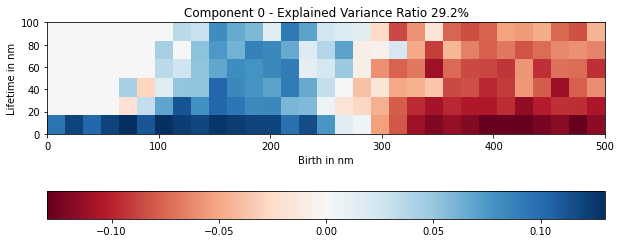

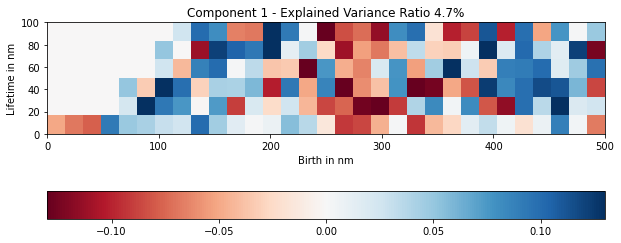

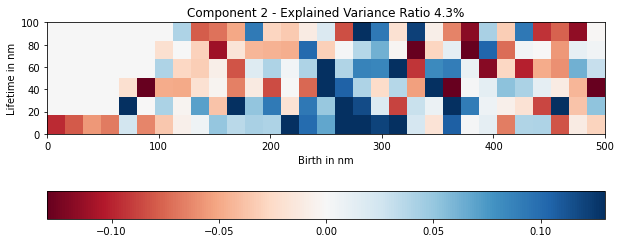

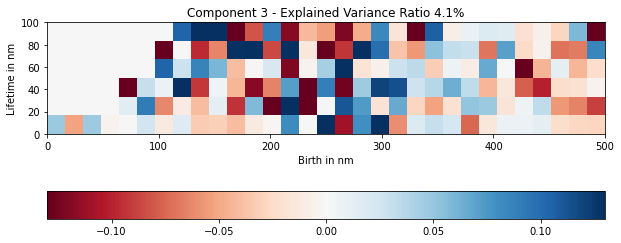

In [9]:
for i in range(4):
    title = "Component " + str(i) +' - Explained Variance Ratio ' +\
          str(np.round(variances[i] * 100, 1 ))+   '%'
    plt.figure(figsize=(10,7))
    plt.title(title )
    vmax = np.max(comp[0])
    vmin = -vmax 
    sc = plt.imshow(comp[i].reshape(globalYDim,globalXDim), cmap = 'RdBu',\
         origin = "lower", extent=[0,limBirth,0,limLifetime], vmin = vmin, vmax = vmax)
    plt.xlabel("")
    plt.xlabel("Birth in nm")
    plt.ylabel("Lifetime in nm")
    plt.colorbar(sc, location = 'bottom' )
    